# Coursework 1 - Crypto

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

## Data preparation

In [2]:
# lodaing data
btc_data = pd.read_parquet('data/bitcoin_historical_data.parquet')
factor_data = pd.read_parquet('data/hw1_factors.parquet')

# data format transformation: string -> float
btc_data['Price'] = btc_data['Price'].str.replace(',', '').astype(float)
factor_data['mkt_rf'] = factor_data['mkt_rf'].astype(float)

# convert to datetime object
btc_data['Date'] = pd.to_datetime(btc_data['Date'])
factor_data['Date'] = pd.to_datetime(factor_data['dt'])
factor_data.drop(columns=['dt'], inplace=True)

# sort datetime
btc_data.sort_values(by='Date', ascending=True, inplace=True)
btc_data.reset_index(inplace=True, drop=True)

# convert percentage to decimals
cols = ['mkt_rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'mom']
factor_data[cols] = factor_data[cols] / 100

In [3]:
btc_data.head()
factor_data.head()

,mkt_rf,smb,hml,rmw,cma,rf,mom,Date
0,-0.0067,0.0002,-0.0035,0.0003,0.0013,0.00012,-0.0021,1963-07-01
1,0.0079,-0.0028,0.0028,-0.0008,-0.0021,0.00012,0.0042,1963-07-02
2,0.0063,-0.0018,-0.0010,0.0013,-0.0025,0.00012,0.0041,1963-07-03
3,0.0040,0.0009,-0.0028,0.0007,-0.0030,0.00012,0.0007,1963-07-05
4,-0.0063,0.0007,-0.0020,-0.0027,0.0006,0.00012,-0.0045,1963-07-08


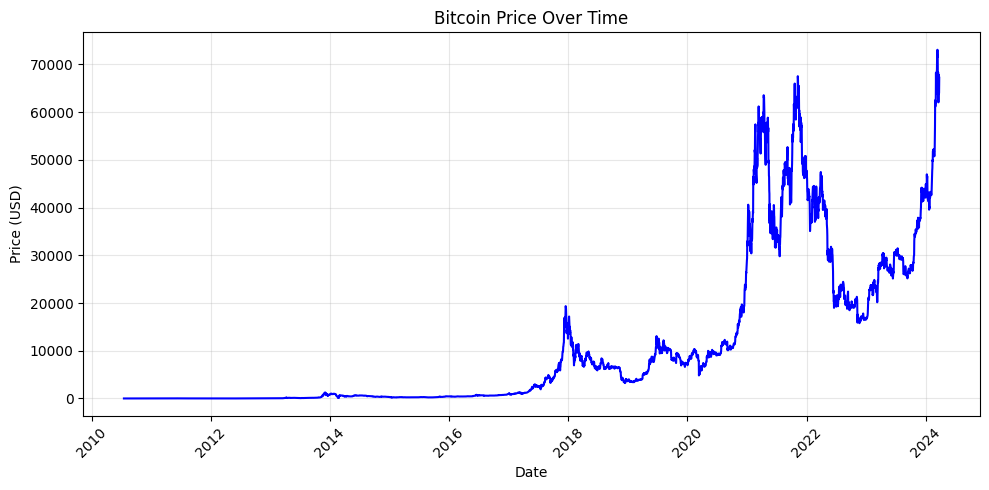

In [4]:
# plot btc_data['Price'] against btc_data['Date']
plt.figure(figsize=(10, 5))
plt.plot(btc_data['Date'], btc_data['Price'], color='blue', linewidth=1.5)
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Q1: Calculation
1. Average arithmetic return
2. Average geometric return
3. Volatility
4. Sharpe ratio
5. 10th, 50th and 90th percentile daily returns

all should be annualised.

### Bitcoin

In [5]:
def calc_stats(returns: pd.Series, periods_per_year=252) -> dict:
  '''
  returns (pd.Series): Array of return (assuming daily)
  periods_per_year: 252 for daily and 12 for monthly data
  return:
    dict: Dictionary containing the calculated statistics:
      - arithmetic_return (float): Annual arithmetic mean return
      - geometric_return (float): Annual geometric mean return
      - volatility (float): Annual volatility
      - sharpe_ratio (float): Annual sharpe ratio
      - percentile_10: 10th percentile return
      - percentile_50: 50th percentile return
      - percentile_90: 90th percentile return
  '''

  arith_return = returns.mean() * periods_per_year
  geo_return = (1 + returns).prod() ** (periods_per_year/returns.count()) - 1
  vol = returns.std() * np.sqrt(periods_per_year)
  sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(periods_per_year)
  percentiles = returns.quantile([0.1, 0.5, 0.9])

  return {
    'arith_return': arith_return,
    'geo_return': geo_return,
    'vol': vol,
    'sharpe_ratio': sharpe_ratio,
    'percentile_10': percentiles.get(0.1),
    'percentile_50': percentiles.get(0.5),
    'percentile_90': percentiles.get(0.9)
  }

In [6]:
# calculate btc price-based return
btc_ret_df = btc_data.copy()
btc_ret_df['Return'] = btc_ret_df['Price'].pct_change()

# calculate stats on full sample, cypto-currencies are traded 365 days a year
btc_stats_full_sample = calc_stats(btc_ret_df['Return'], periods_per_year=365)

In [7]:
# calculate stats for 2017 onwards
btc_returns_post_2017 = btc_ret_df[btc_ret_df['Date'] >= '2017-01-01']['Return']
btc_stats_post_2017 = calc_stats(btc_returns_post_2017, periods_per_year=365)

In [8]:
# calculate stats for pre-2017
btc_returns_pre_2017 = btc_ret_df[btc_ret_df['Date'] < '2017-01-01']['Return']
btc_stats_pre_2017 = calc_stats(btc_returns_pre_2017, periods_per_year=365)

In [9]:
# combine in a dataframe
btc_stats_df = pd.DataFrame([btc_stats_full_sample, btc_stats_post_2017, btc_stats_pre_2017], 
                            index=['BTC Full Sample', 'BTC Post-2017', 'BTC Pre-2017'])

### US market

In [10]:
# construct non-excess return on the US market
mkt_returns = factor_data['mkt_rf'] + factor_data['rf']
mkt_stats_full_sample = calc_stats(mkt_returns)

In [11]:
mkt_data_post_2017 = factor_data[factor_data['Date'] >= '2017-01-01'][['mkt_rf', 'rf']]
mkt_ret_post_2017 = mkt_data_post_2017['mkt_rf'] + mkt_data_post_2017['rf']
mkt_stats_post_2017 = calc_stats(mkt_ret_post_2017)

In [12]:
mkt_data_pre_2017 = factor_data[factor_data['Date'] < '2017-01-01'][['mkt_rf', 'rf']]
mkt_ret_pre_2017 = mkt_data_pre_2017['mkt_rf'] + mkt_data_pre_2017['rf']
mkt_stats_pre_2017 = calc_stats(mkt_ret_pre_2017)

In [13]:
mkt_stats_df = pd.DataFrame([mkt_stats_full_sample, mkt_stats_post_2017, mkt_stats_pre_2017], 
                            index=['MKT Full Sample', 'MKT Post-2017', 'MKT Pre-2017'])

In [14]:
result_df = pd.concat([btc_stats_df, mkt_stats_df])
print('==== Non-Excess Return comparison ====')
result_df

==== Non-Excess Return comparison ====


,arith_return,geo_return,vol,sharpe_ratio,percentile_10,percentile_50,percentile_90
BTC Full Sample,1.731702,1.664243,1.462010,1.184467,-0.038671,0.000000,0.047108
BTC Post-2017,0.865006,0.798445,0.741633,1.166354,-0.038656,0.001383,0.045192
BTC Pre-2017,2.702048,3.136778,1.977593,1.366332,-0.038551,0.000000,0.052456
MKT Full Sample,0.114931,0.107119,0.161840,0.710156,-0.010300,0.000700,0.010880
MKT Post-2017,0.158060,0.149857,0.191280,0.826327,-0.011700,0.000760,0.012310
MKT Pre-2017,0.108556,0.100938,0.157024,0.691333,-0.010170,0.000690,0.010592


### Risk Comparison: Bitcoin vs. US Equities

#### Sharpe Ratio Analysis
- Bitcoin generally exhibits a higher Sharpe ratio compared to US equities, particularly in the pre-2017 period. This suggests that Bitcoin has historically delivered better risk-adjusted returns relative to its volatility.
- However, the Sharpe ratio alone does not fully capture the risk profile, as it focuses on average returns and total volatility, not extreme downside events.

#### Drawdown Analysis
- Bitcoin demonstrates significantly higher volatility, with a full-sample volatility of **1.46** compared to the market's **0.16**. This indicates greater price fluctuations and higher risk of significant losses.
- Bitcoin's 10th percentile returns are more negative than those of US equities, meaning its worst 10% of returns are significantly worse. This highlights Bitcoin's higher exposure to extreme downside events (drawdowns).

## Q2
Price based return in crypto are incomplete because we potentially have other sources of return such as staking generation, where many cryptocurrencies allow holders to earn 3-15% annual percentage yeild through staking rewards. Other sources of return also include: Lending through DeFi platforms, mining rewards, and airdrop/forks.

## Q3

In [25]:
# merge data using inner join
merged_df = pd.merge(btc_data, factor_data, how='inner', on='Date')

# construct BTC excess return
merged_df['btc_rf'] = merged_df['Price'].pct_change() - merged_df['rf']
merged_df = merged_df.dropna()

# run regression
model1 = sm.OLS(merged_df['btc_rf'], sm.add_constant(merged_df['mkt_rf'])).fit()

#pre-2017
filtered_df = merged_df[merged_df['Date'] < '2017-01-01']
model2 = sm.OLS(filtered_df['btc_rf'], sm.add_constant(filtered_df['mkt_rf'])).fit()

# post-2016
filtered_df2 = merged_df[merged_df['Date'] > '2016-12-31']
model3 = sm.OLS(filtered_df2['btc_rf'], sm.add_constant(filtered_df2['mkt_rf'])).fit()

In [26]:
# gather outputs
output = Stargazer([model1, model2, model3])
output.custom_columns(['Full Sample', 'Pre-2017', 'Post-2016'])
output.title("Regression Analysis of Bitcoin Excess Returns")
output

#### Analysis

1. What is the market beta of bitcoin:
The market beta of bitcoin on the full sample is 0.619. The market beta of bitcoin before 2017 and after 2016 is 0.343 is 0.929 respectively. The result shows that the pre-2017 regression beta is statistically insiginificant.

2. How does beta differ between periods:
The beta jumpped significantly and it indicates that bitcoin became more sensitive to the market movement. Also beta transitioned from no meaningful correlation to near-parity with market movements.

3. Tracking tightness:
Despite high beta after 2016, the R-squared value of the regression remains low (0.062), which indicates that market explains less than 7% of Bitcoin's price variance and more than 93% of Bitcoin's movement remains crypto-specific.

4. Why beta differs:
Potential reasons could be that Bitcoin is becoming more mature with time and hence it becomes more correlated with tech stocks. Another possible reason is that institutional adoption (futures, ETFs) tied Bitcoin to traditional portfolios.

5. Is Bitcoin a levered bet on the equity market?
By inspecting the beta magnitude, which is 0.929 (less than 1), it is not accurate to say Bitcoin is levered relative to market. However, Bitcoin's absolute volatility is extremely high compared to that of the stock market. In this sense, we could say that Bitcoin is somehow levered.

## Q4

In [27]:
# combine data
merged_df = pd.merge(btc_data, factor_data, how='inner', on='Date')
merged_df.set_index('Date', inplace=True)
merged_df['btc_rf'] = merged_df['Price'].pct_change() - merged_df['rf']

# filter data for analysis since 2017
merged_df = merged_df[merged_df.index >= '2017-01-01']

compound_cols = ['btc_rf', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma', 'mom']

# we need to construct monthly excess return in order to be comparable to the RFS publication
monthly_df = merged_df[compound_cols].resample('ME').apply(lambda x: (x + 1).prod() - 1)

# Define factor combinations for different Fama-French models
factor_combinations = {
    'FF3': ['mkt_rf', 'smb', 'hml'],
    'FF4': ['mkt_rf', 'smb', 'hml', 'mom'],
    'FF5': ['mkt_rf', 'smb', 'hml', 'rmw', 'cma'],
    'FF6': ['mkt_rf', 'smb', 'hml', 'rmw', 'cma', 'mom']
}

# Create dictionary to store models
models = {}

# Loop through each factor combination
for model_name, factors in factor_combinations.items():
    # Select factors and add constant
    X = sm.add_constant(monthly_df[factors])
    y = monthly_df['btc_rf']

    # Fit OLS model
    model = sm.OLS(y, X).fit()
    
    # Store model in dictionary
    models[model_name] = model
    

# ======show output======
stargazer = Stargazer(list(models.values()))
stargazer.custom_columns(list(models.keys()))
stargazer.title("Fama-French Factor Models for Bitcoin Excess Returns (Monthly)")
stargazer.show_model_numbers(False)
stargazer.significant_digits(3)

stargazer

*The Bitcoin's return are not explained by the Fama-French factors, because the coefficients in the regression are not statistically significant. Hence Bitcoin provides diversification benefits, it is additive to the portfolio.

**Analysis of Bitcoin's Additive Value Post-2017**

From the above regression table, take FF6 for example, we have a few key observations:

1. The R-sqaured value is low (3.9%), this indicates that Fama-French factors explains a very small portion of Bitcoin's returns and a large portion of variance remains crypto-specific.

2. We observe some statistically significant factor coefficients: market beta, SMB, HML. 

3. We see that Bitcoin has no momentum or CMA exposure.

From the above observations, we give the conclusion that Bitcoin is additive to the Fama-French factor portfolio, given data since 2017.

1. Low R-squared value suggests portfolio diversification benefits.

2. Negative exposure to RMW and HML factors provides hedge against quility stocks.

3. Pretty significant monthly alpha of around 5%.

However, we should also be cautious that high market beta creates equity correlation risk.

**Comparison to the publication "Risks and Returns of Cryptocurrency" in RFS**

My results shows pretty big difference in Bitcoin's relationship with traditional factors compared to the original RFS findings. I want to note that the above regression are adjusted monthly to be comparable to RFS paper.

Our monthly alpha is around 5% which is lower than the numbers in the paper, our market beta is a lot higher, and our R-squared is notably higher. The explaination for this is the result from the RFS paper uses data from 2010 to 2018, while we used data from 2017 onwards. Despite the difference from the paper, our results still show great potential to add Bitcoin in the Fama-French portfolios.

## Q5
**Long-term rationale in cryptocurrency**

Unlike the S&P 500, which has cash flows, crypto's value is more about consensus and perceived utility. So while S&P 500's value is tied to company earnings and discount rates, crypto's value is more speculative and based on factors like adoption, technological progress and market psychology. For example, crypto offers an alternative to centralized financial systems, particularly in regions with unstable currencies or restrictive capital controls. This utility could sustain long-term demand.

**Drivers for high return expectation**

Cryptocurrencies are relatively new compared to traditional assets. Early adoption phases in disruptive technologies historically yield high returns as markets mature (e.g., internet stocks in the 1990s). Also, increasing institutional participation (e.g., ETFs, corporate treasuries) and retail speculation amplify volatility but also create upward price momentum.

**Mispricing and Non-Fundamental Drivers**

Unlike equities, cryptos lack cash flows or dividends, making valuation subjective. There is no proper pricing model that fits cryptocurrency, so the price often reflect speculation rather than fundamentals. 

**BTC hitting $1,000,000**

Todo

## Q6

=====Monthly Cumulative Return Comparison=====


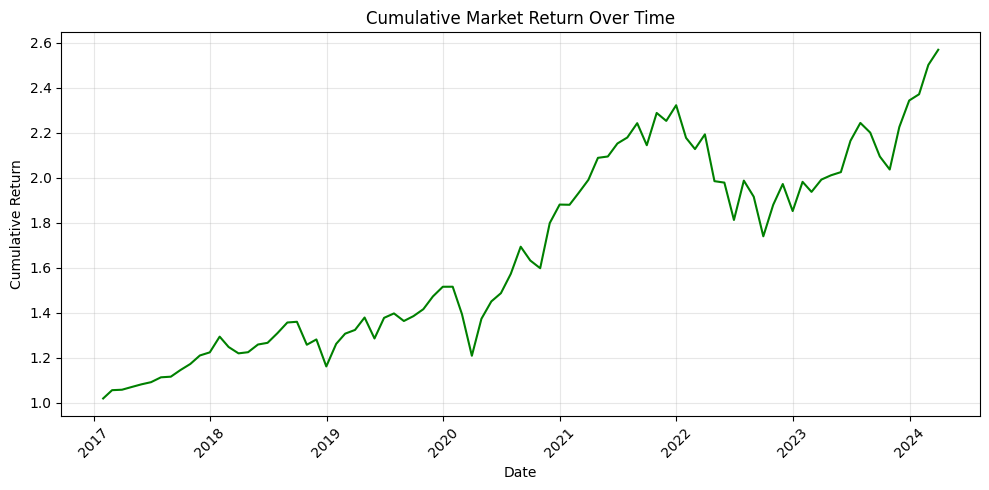

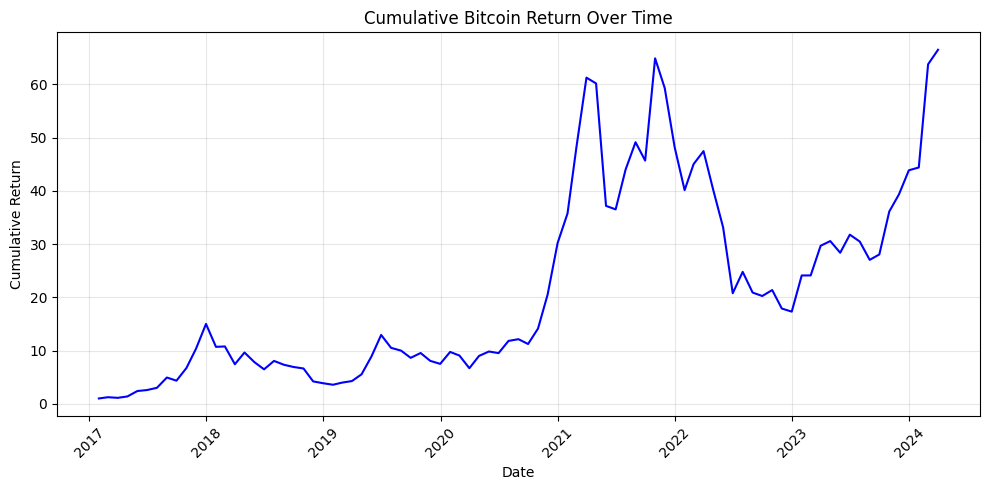

In [112]:
# Plotting market non-excess cumulative return:
merged_df = pd.merge(btc_data, factor_data, how='inner', on='Date')
merged_df.set_index('Date', inplace=True)
merged_df['btc_ret'] = merged_df['Price'].pct_change()
merged_df['mkt_ret'] = merged_df['mkt_rf'] + merged_df['rf']

filtered_df = merged_df[merged_df.index >= '2017-01-01']

# resample monthly
compound_cols = ['btc_ret', 'mkt_ret', 'mkt_rf', 'smb', 'hml', 'rmw', 'cma', 'mom']
monthly_df = filtered_df[compound_cols].resample('ME').apply(lambda x: (x + 1).prod() - 1)

print('=====Monthly Cumulative Return Comparison=====')

cum_mkt_ret = (1 + monthly_df['mkt_ret']).cumprod() - 1
cum_btc_ret = (1 + monthly_df['btc_ret']).cumprod() - 1

plt.figure(figsize=(10, 5))
plt.plot(monthly_df.index, cum_mkt_ret + 1, color='green', linewidth=1.5)
plt.title('Cumulative Market Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot cumulative Bitcoin return
plt.figure(figsize=(10, 5))
plt.plot(monthly_df.index, cum_btc_ret + 1, color='blue', linewidth=1.5)
plt.title('Cumulative Bitcoin Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Taking Monthly Bets**

To place the monthly bet that Bitcoin outperforms the S&P 500, the general idea is to take the long position in BTC and short S&P 500. Let's use the US market data to represent S&P 500.

In [138]:
# constructing equal-weighted long-short portfolio returns
portfolio_df = monthly_df.copy()
portfolio_df['long_short_ret'] = 0.5*portfolio_df['btc_ret'] - 0.5*portfolio_df['mkt_ret']
portfolio_df['long_short_cum_ret'] = (1 + portfolio_df['long_short_ret']).cumprod() - 1

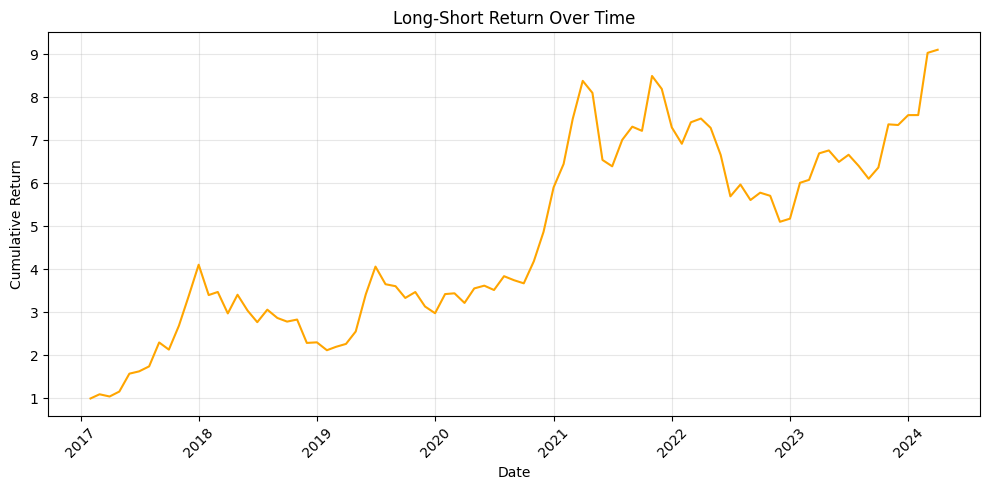

=====Long-short portfoilo Performance Comparison=====
                 Market   Bitcoin  Long-Short
arith_return   0.145488  0.912047    0.383279
geo_return     0.138946  0.784165    0.356062
vol            0.171903  0.843701    0.401315
sharpe_ratio   0.846340  1.081007    0.955059
percentile_10 -0.061497 -0.180544   -0.098571
percentile_50  0.018705  0.029785    0.011705
percentile_90  0.069191  0.440717    0.181799


In [139]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(monthly_df.index, portfolio_df['long_short_cum_ret'] + 1, color='orange', linewidth=1.5)
plt.title('Long-Short Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('=====Long-short portfoilo Performance Comparison=====')
# Calculate statistics for both portfolios
market_stats = calc_stats(monthly_df['mkt_ret'], periods_per_year=12)
btc_stats = calc_stats(monthly_df['btc_ret'], periods_per_year=12)
long_short_stats = calc_stats(portfolio_df['long_short_ret'], periods_per_year=12)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Market': market_stats,
    'Bitcoin': btc_stats,
    'Long-Short': long_short_stats
})

# Print the comparison table
print(comparison_df)

Although not ideal, equal-weighted long/short portfolio does give a higher sharpe ratio than the market portfolio.

/var/folders/40/m24m56td08b_d5vqj9mv7ty40000gn/T/ipykernel_47426/870371920.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_vol = merged_df[['btc_vol_d', 'mkt_vol_d']].resample('M').last()


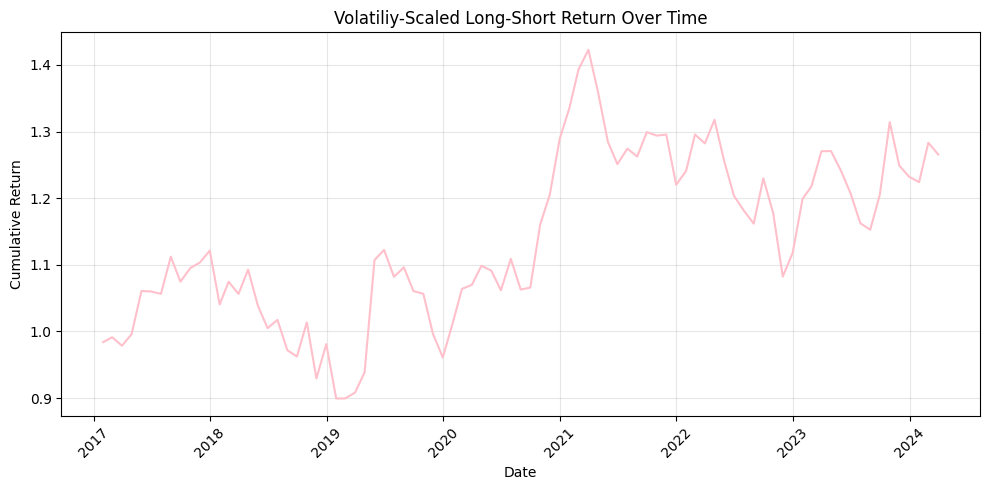

=====Volatility-Scaled Long-short portfoilo Performance Comparison=====
                 Market   Bitcoin  Equal Long/Short  Vol Long/Short
arith_return   0.145488  0.912047          0.766559        0.043850
geo_return     0.138946  0.784165          0.596572        0.033015
vol            0.171903  0.843701          0.802630        0.152746
sharpe_ratio   0.846340  1.081007          0.955059        0.287077
percentile_10 -0.061497 -0.180544         -0.197143       -0.048516
percentile_50  0.018705  0.029785          0.023410        0.000228
percentile_90  0.069191  0.440717          0.363597        0.053361


In [130]:
portfolio_df = monthly_df.copy()
portfolio_df['long_short_ret'] = portfolio_df['btc_ret'] - portfolio_df['mkt_ret']
portfolio_df['long_short_cum_ret'] = (1 + portfolio_df['long_short_ret']).cumprod() - 1

# Volatility-Scaled Long-Short Strategy
# half-year lookback window
lookback = 126

# window vol (daily scale)
merged_df['btc_vol_d'] = merged_df['btc_ret'].rolling(lookback).std()
merged_df['mkt_vol_d'] = merged_df['mkt_ret'].rolling(lookback).std()

monthly_vol = merged_df[['btc_vol_d', 'mkt_vol_d']].resample('M').last()

# monthly vol
portfolio_df = portfolio_df.merge(
    monthly_vol,
    left_index=True,
    right_index=True,
    how='left'
)

portfolio_df['btc_vol'] = portfolio_df['btc_vol_d'] * np.sqrt(21)
portfolio_df['mkt_vol'] = portfolio_df['mkt_vol_d'] * np.sqrt(21)

# Compute inverse volatility weights
portfolio_df['btc_weight'] = 1 / portfolio_df['btc_vol']
portfolio_df['mkt_weight'] = 1 / portfolio_df['mkt_vol']

# Normalize weights to sum to 1
total_weight = portfolio_df['btc_weight'] + portfolio_df['mkt_weight']
portfolio_df['btc_weight'] /= total_weight
portfolio_df['mkt_weight'] /= total_weight

# Calculate strategy returns (long BTC, short market)
portfolio_df['vol_long_short_ret'] = (
    portfolio_df['btc_weight'] * portfolio_df['btc_ret'] -
    portfolio_df['mkt_weight'] * portfolio_df['mkt_ret']
)

# Calculate cumulative returns
portfolio_df['vol_long_short_cum_ret'] = (1 + portfolio_df['vol_long_short_ret']).cumprod() - 1

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(monthly_df.index, portfolio_df['vol_long_short_cum_ret'] + 1, color='pink', linewidth=1.5)
plt.title('Volatiliy-Scaled Long-Short Return Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('=====Volatility-Scaled Long-short portfoilo Performance Comparison=====')
# Calculate statistics for both portfolios
market_stats = calc_stats(monthly_df['mkt_ret'], periods_per_year=12)
btc_stats = calc_stats(monthly_df['btc_ret'], periods_per_year=12)
long_short_stats = calc_stats(portfolio_df['long_short_ret'], periods_per_year=12)
vol_long_short_stats = calc_stats(portfolio_df['vol_long_short_ret'], periods_per_year=12)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Market': market_stats,
    'Bitcoin': btc_stats,
    'Equal Long/Short': long_short_stats,
    'Vol Long/Short': vol_long_short_stats
})

# Print the comparison table
print(comparison_df)

Volatility-scaled long/short strategy: worth a shot, but doesn't perform so well. Although not ideal, but every month we adjust the weights using 1/vol of the previous 6-months returns. The lookback window is adjustable.

## Q7

In [182]:
merged_df = pd.merge(btc_data, factor_data, how='inner', on='Date')
merged_df.set_index('Date', inplace=True)
merged_df['btc_ret'] = merged_df['Price'].pct_change()
merged_df['btc_rf'] = merged_df['btc_ret'] - merged_df['rf']
merged_df['mkt_ret'] = merged_df['mkt_rf'] + merged_df['rf']

filtered_df = merged_df[merged_df.index >= '2017-01-01']

In [202]:
def market_neutral_strategy(df, lookback=252):
    """
    Market-neutral strategy using rolling beta hedging (OLS regression).
    """
    df = df.copy()
    df['beta'] = np.nan
    
    # Calculate rolling beta using OLS
    for i in range(lookback, len(df)):
        window = df.iloc[i-lookback:i]
        X = sm.add_constant(window['mkt_rf'])
        model = sm.OLS(window['btc_rf'], X, missing='drop').fit()
        df.iloc[i, df.columns.get_loc('beta')] = model.params['mkt_rf']

    # Calculate hedged returns
    df['hedged_ret'] = df['btc_ret'] - df['beta'] * df['mkt_ret']
    return df

In [208]:
portfolio_df = market_neutral_strategy(filtered_df, lookback=252)
portfolio_df.dropna(inplace=True)
portfolio_df[['btc_ret', 'beta', 'mkt_ret', 'hedged_ret']].head()

,btc_ret,beta,mkt_ret,hedged_ret
Date,,,,
2018-01-03,0.027281,0.746507,0.00596,0.022831
2018-01-04,0.001550,0.672389,0.00426,-0.001314
2018-01-05,0.116910,0.552397,0.00666,0.113231
2018-01-08,-0.116699,0.586887,0.00196,-0.117849
2018-01-09,-0.013201,0.607030,0.00156,-0.014148


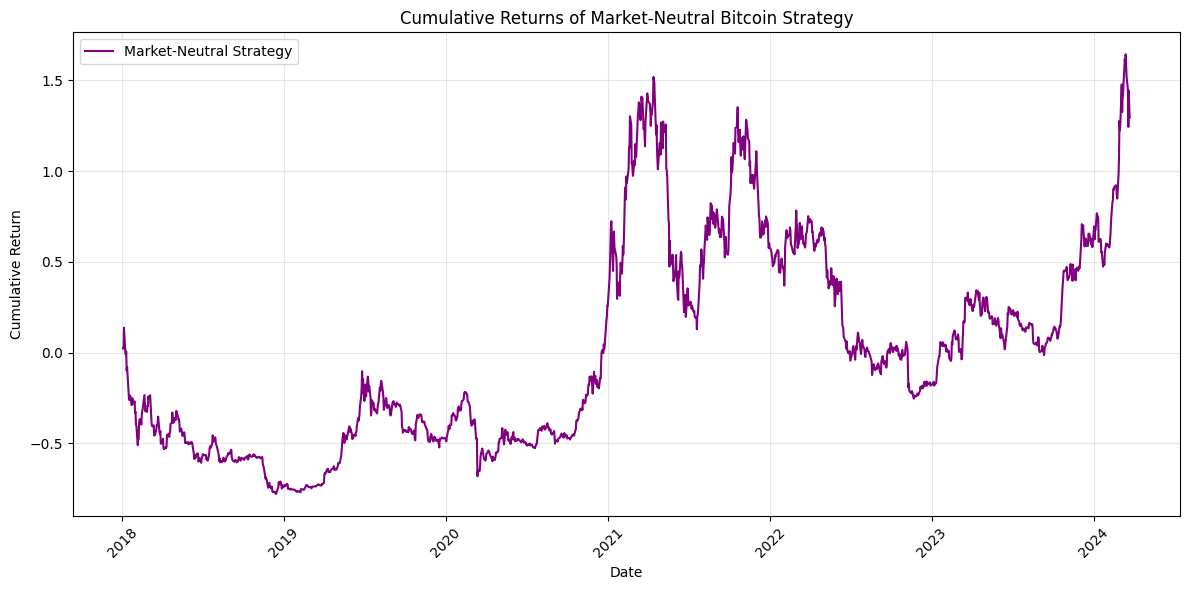

=====Market-Neutral Strategy Performance=====
               mkt_neutral_stats
arith_return            0.363628
geo_return              0.143086
vol                     0.671984
sharpe_ratio            0.541125
percentile_10          -0.041866
percentile_50           0.000013
percentile_90           0.049490


In [210]:
# Calculate cumulative returns
portfolio_df['hedged_cum_ret'] = (1 + portfolio_df['hedged_ret']).cumprod() - 1

# Plot
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df.index, portfolio_df['hedged_cum_ret'], label='Market-Neutral Strategy', color='purple', linewidth=1.5)
plt.title('Cumulative Returns of Market-Neutral Bitcoin Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print('=====Market-Neutral Strategy Performance=====')
# Calculate statistics for both portfolios
mkt_neutral_stats = calc_stats(portfolio_df['hedged_ret'], periods_per_year=252)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'mkt_neutral_stats': mkt_neutral_stats
})

# Print the comparison table
print(comparison_df)

The above graph is the market-neutral strategy from 2018 onwards (used 1-year rolling window beta). Taking the previous post-2016 regression result as an example, the market beta of Bitcoin is 0.929. For every dollar we invest on the Bitcoin, we need to short 0.929 dollar of SPY.

**What could go wrong**

1. We used rolling window of beta, which uses the historical value to estimate the current market beta, which could cause inaccuracy.

2. As described in the question, if we used estimated beta of 2016-2025 to hedge in 2018, we can't know future data in real life.

3. The selection of rolling windows size is subjective, it is impossible to perfectly hedge beta risk.